In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from PIL import Image

from app.retriever.client import ColpaliClient

images = ["../previews/32/33.jpg"]
test_query = "Как за 10 лет изменилось количество телепрограмм, привлекающих более 4-х млн. зрителей в Великобритании?"

image = Image.open(images[0])
client = ColpaliClient("ml.n19", 6339)
image_embeddings = client.embed_images(images)

text_embeddings = client.embed_texts([test_query])
text_embeddings.shape

In [ ]:
import matplotlib.pylab as plt
import numpy as np
import torch
from colpali_engine.interpretability import (
    get_similarity_maps_from_embeddings,
    normalize_similarity_map,
)
from colpali_engine.models import ColPaliProcessor
from einops import rearrange

model_name = "vidore/colpali-v1.2"
# Load the processor
processor = ColPaliProcessor.from_pretrained(model_name)
batch_images = processor.process_images([image])

image_mask = processor.get_image_mask(batch_images)
n_patches = processor.get_n_patches(image_size=image.size, patch_size=14)


# Generate the similarity maps
batched_similarity_maps = get_similarity_maps_from_embeddings(
    image_embeddings=torch.from_numpy(image_embeddings),
    query_embeddings=torch.from_numpy(text_embeddings),
    n_patches=n_patches,
    image_mask=image_mask,
)

query_tokens = processor.tokenizer.tokenize(test_query)

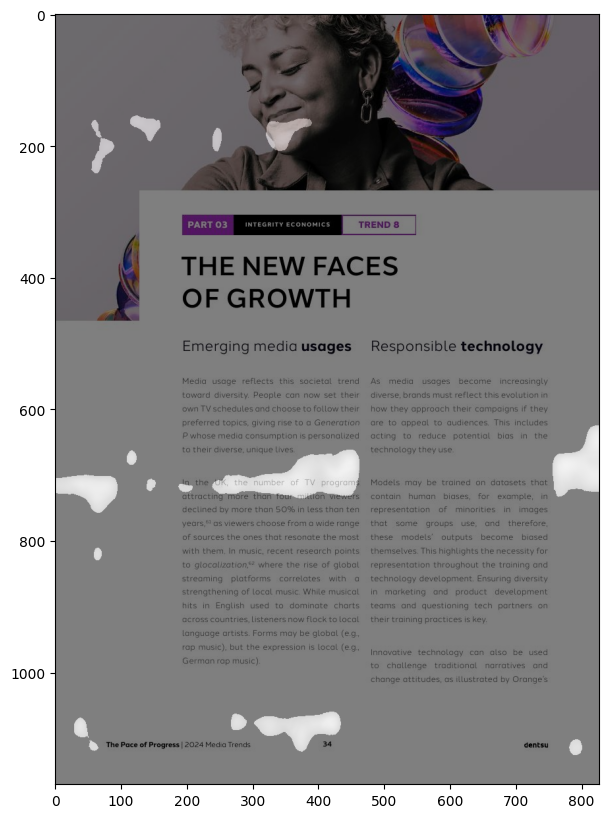

In [ ]:
# [pin]
# извлекаем матрицы внимания для первой картинки из батча
similarity_maps = batched_similarity_maps[0]  # (query_length, n_patches_x, n_patches_y)

# получаем вероятности и транспонируем по всем текстовым токенам
similarity_maps = [
    rearrange(
        normalize_similarity_map(sm).to(torch.float32).cpu().numpy(), "h w -> w h"
    )
    for sm in similarity_maps
]

# преобразуем в хитмапы картинки - ресайзим из 32x32 в исходный размер
similarity_maps = [
    Image.fromarray((sm * 255).astype(np.uint8)).resize(
        image.size, Image.Resampling.BICUBIC
    )
    for sm in similarity_maps
]

# взвешенно складываем для отрисовки
similarity_maps = [np.array(sm) for sm in similarity_maps]
alpha = 0.5
heatmap = np.median(similarity_maps, 0)[..., None]
heatmap_mask = heatmap > np.percentile(heatmap, 97)
heatmap[heatmap_mask == 0] = 0

heatmap = np.repeat(heatmap * (1 - alpha), 3, -1)
img_array = np.array(image) * alpha + heatmap
plt.figure(figsize=(10, 10))
plt.imshow(img_array.astype(np.uint8))

In [ ]:
np.array(similarity_maps[0]).min()

In [ ]:
import matplotlib.pylab as plt

plt.imshow(similarity_maps[0])

In [ ]:
from pathlib import Path

import numpy as np

arrays = []
for image in Path("./").glob("similarity*"):
    arrays.append(np.array(Image.open(image)))

heatmap = np.stack(arrays, axis=0).mean(0)

In [ ]:
heatmap.shape

In [ ]:
heatmap.max()

In [ ]:
import matplotlib.pylab as plt

plt.figure(figsize=(10, 10))
plt.imshow(heatmap / 255)
plt.show()